In [50]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from utils_gc import *
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [75]:
train_df = pd.read_csv('train_imputed_232_4.csv')
test_df  = pd.read_csv('test_imputed_232_4.csv')

In [3]:
num_train   = train_df.shape[0]

#merged train-test for categorical imputation
data_merged = pd.concat([train_df,test_df],axis=0)
data_enc    = enc_data(data_merged)

# Split data
train = data_enc.iloc[0:num_train, ]
test  = data_enc.iloc[num_train:, ]
print(train.shape, test.shape)

(91713, 62) (39308, 62)


In [4]:
cat_features = ['gender','icu_admit_source', 'icu_stay_type', 'icu_type','apache_3j_diagnosis','apache_3j_bodysystem', 'ethnicity',
               'hospital_id']

In [33]:
# 'solid_tumor_with_metastasis', 'diabetes_mellitus', 'intubated_apache', 'elective_surgery', 'arf_apache', 'apache_post_operative',
#                'hepatic_failure', 'immunosuppression','cirrhosis','leukemia', 'lymphoma','aids'

In [5]:
X_train = train.drop(['encounter_id', 'hospital_death'], axis=1)
y_train = train['hospital_death'].values

X_test = test.drop(['encounter_id', 'hospital_death'], axis=1)

In [7]:
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 101, stratify=y_train)

In [43]:
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 10, alpha = 10, n_estimators = 100, eval_metric = 'auc', 
                early_stopping_rounds=1000, 
                verbose_eval=150)
    
pred_test_y  = model.fit(dev_X,dev_y)

In [48]:
y_pred = model.predict(val_X)
predictions = [round(value) for value in y_pred]

In [51]:
accuracy = accuracy_score(val_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.45%


# Model applied to test data

In [72]:
y = test.hospital_death
x = X_test

In [73]:
y_pred = model.predict(x)
predictions = [round(value) for value in y_pred]

In [93]:
test['hospital_death'] = y_pred
test[['encounter_id','hospital_death']].to_csv('james.csv', index=False)

C:\Users\wanyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


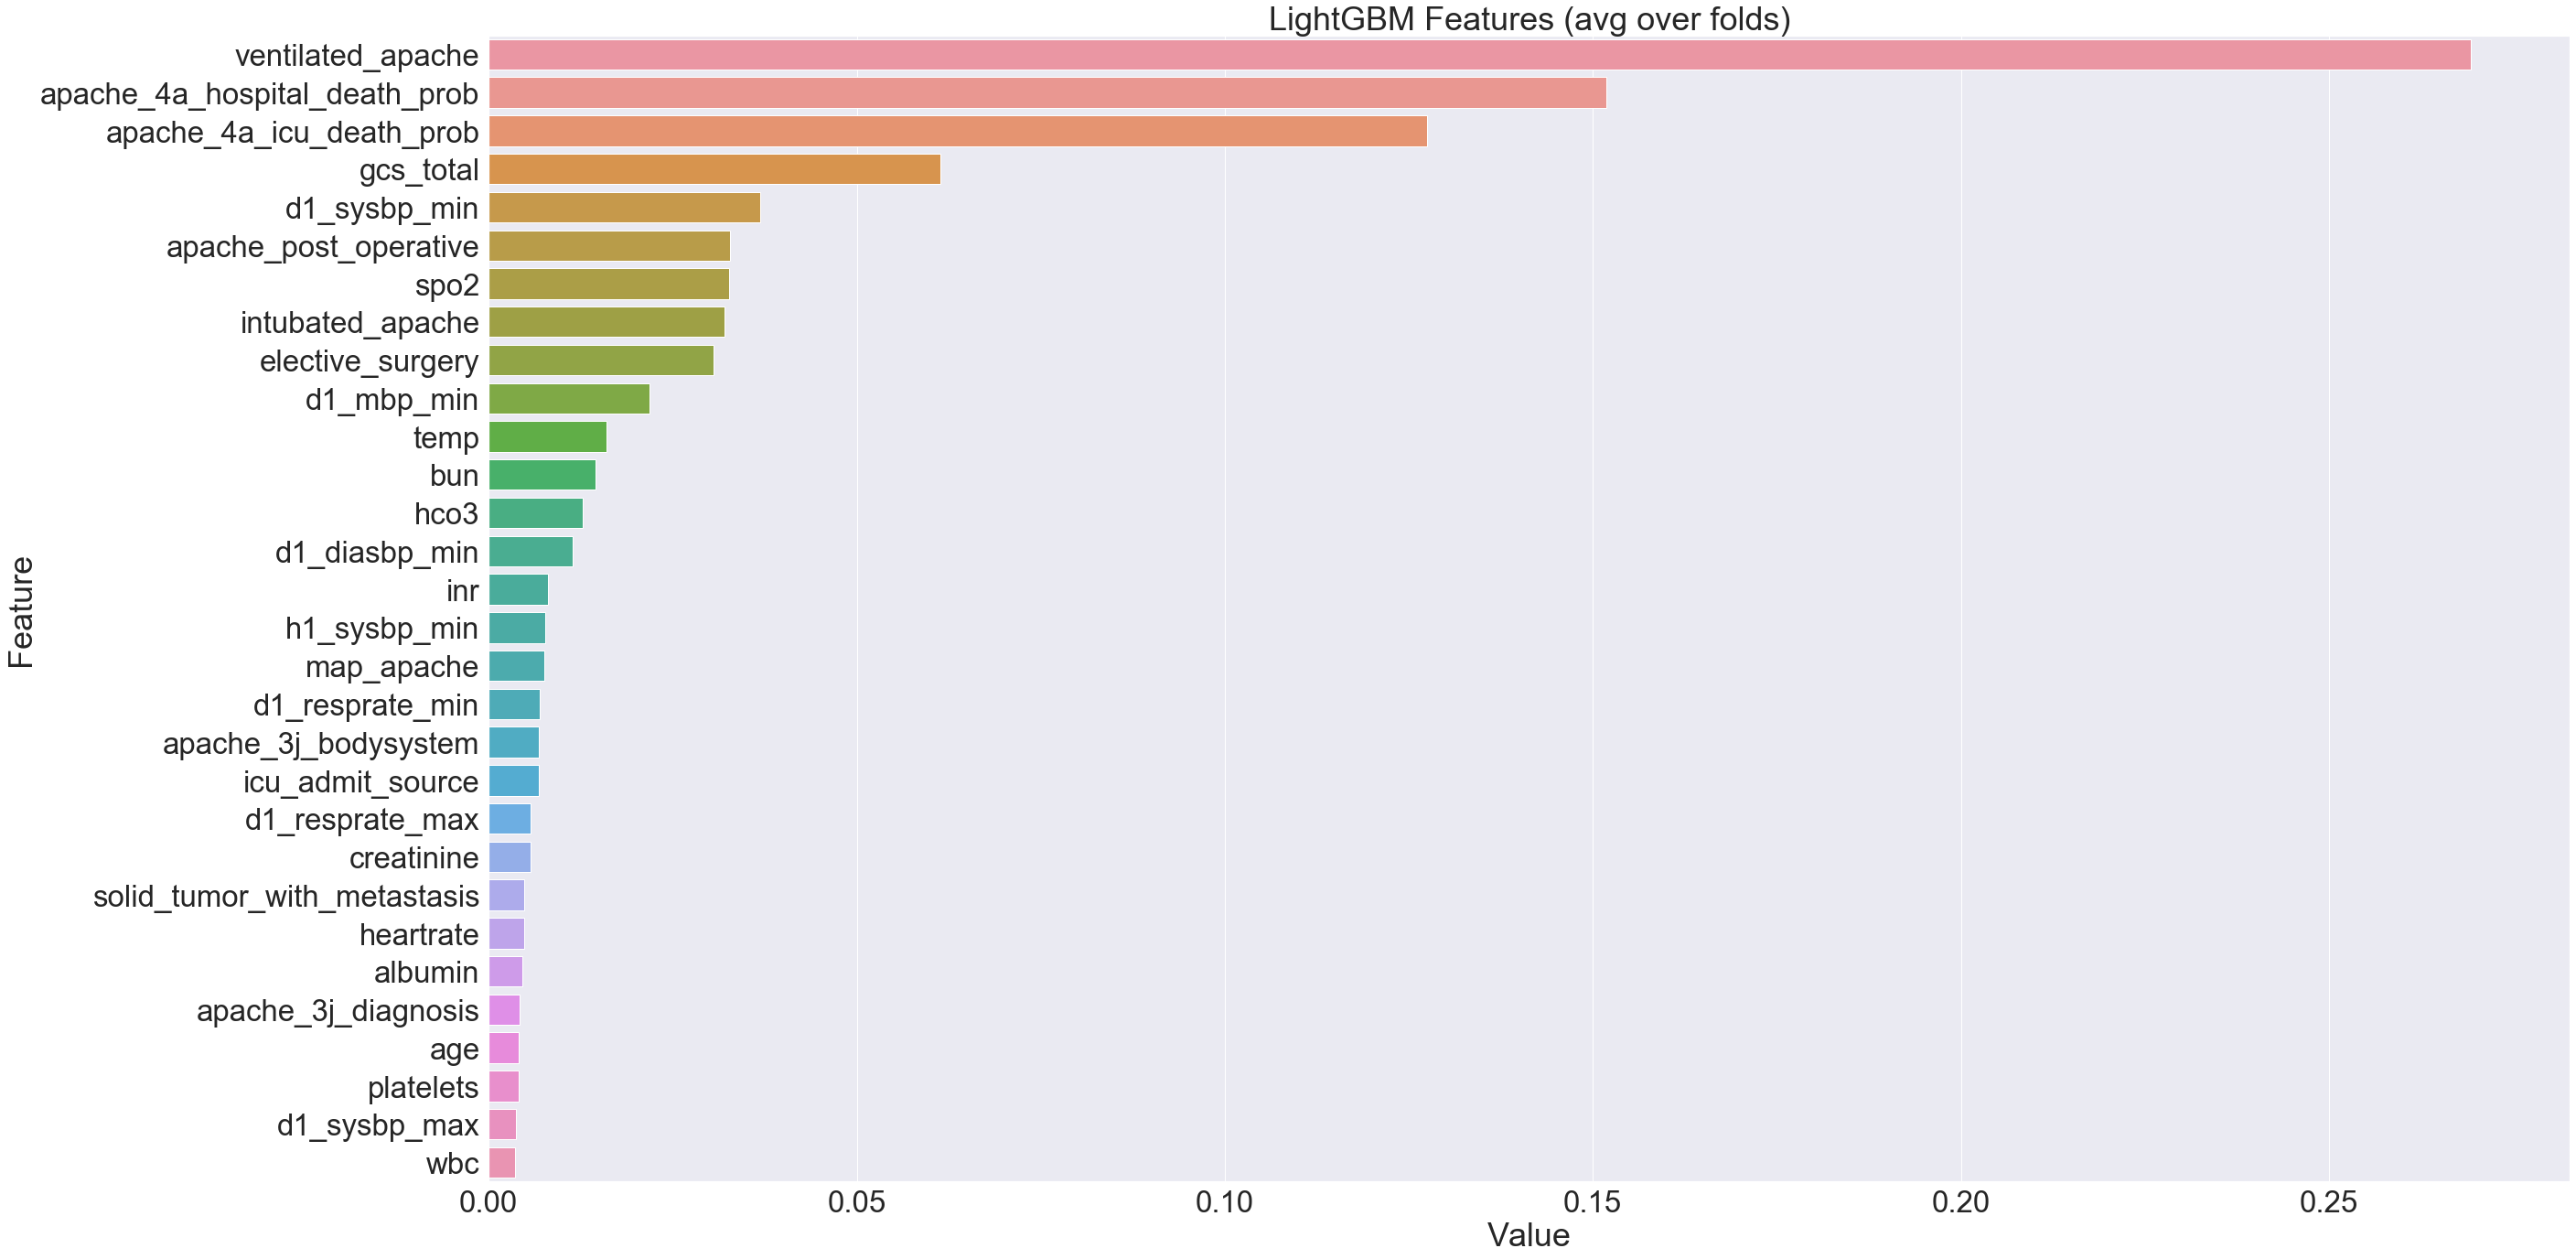

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:30])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-09.png')
plt.show()